In [1]:
from pymongo import MongoClient
from os import environ
import tiktoken
import pandas as pd
import seaborn as sns

from typing import List

from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.globals import set_verbose

set_verbose(True)

In [2]:
client = MongoClient(environ["MONGODB_URI"])

In [3]:
MODEL = "gpt-3.5-turbo"

COST_PER_TOKEN = {
    "gpt-4": 30 / 10**6,
    "gpt-3.5-turbo": 0.5 / 10**6,
}

MAX_TOKENS = {
    "gpt-4": 32_768,
    "gpt-3.5-turbo": 16_385,
}

In [4]:
def count_tokens(text, model=MODEL):
    # https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
    encoding = tiktoken.encoding_for_model(model)
    return 3 + len(encoding.encode(text))

In [5]:
agg = [
    {
        "$match": {
            "text": {
                "$exists": True
            }
        }
    },
    {
        "$sample": {
            "size": 20
        }
    },
]

token_counts = []
for doc in client['juddges']['judgements'].aggregate(agg):
    num_tokens = count_tokens(doc['text'])
    token_counts.append({
        "_id": doc["_id"],
        "num_tokens": num_tokens
    })

token_counts_df = pd.DataFrame.from_records(token_counts)
token_counts_df

,_id,num_tokens
0,150515000003506_VII_Ka_000797_2015_Uz_2015-10-...,2544
1,152510000004021_VIII_U_000790_2020_Uz_2020-10-...,977
2,152510050000503_I_C_000830_2019_Uz_2020-02-11_001,14858
3,151515250002521_V_U_000283_2019_Uz_2020-08-11_002,5355
4,154505300005506_XI_W_001544_2015_Uz_2015-12-02...,4913
5,154505200000503_I_C_002148_2020_Uz_2021-10-21_001,4519
6,152510000004021_VIII_U_002767_2021_Uz_2022-03-...,5575
7,152510150004003_VIII_C_002116_2017_Uz_2018-04-...,5660
8,154500000003003_VI_ACa_000254_2013_Uz_2013-10-...,10993
9,151015150000503_I1_C_000182_2019_Uz_2019-09-04...,13026


In [6]:
estimated_cost = token_counts_df["num_tokens"].sum() * COST_PER_TOKEN[MODEL]

print(f"Estimated cost: ${estimated_cost:,.2f}")

Estimated cost: $0.06


<Axes: xlabel='num_tokens', ylabel='Count'>

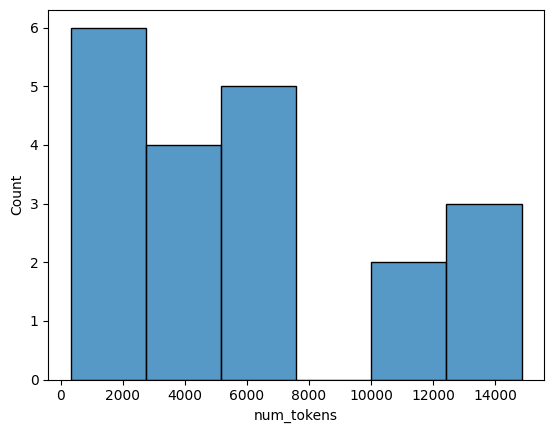

In [7]:
sns.histplot(
    data=token_counts_df,
    x="num_tokens",
)

In [8]:
INSTRUCTION = '''\
You are a question-answer generator. Your goal is to generate question-answer pairs given the Context.
Do not tranlate the Context, generate questions and answers in original language.

Context: {context}

Step 1: Identify spans that are likely to be answers to questions, identify as many as possible.
Step 2: For each identified span, generate a question.
Step 3: Respond to the question in only a few tokens concisely.

Ensure that you distinctly label and delineate Steps 1, 2 and 3.

{format_instructions}

Output:
```{format_md_ext}
'''

In [9]:
# Define your desired data structure.
class SyntheticLegisQAPairs(BaseModel):
    questions: List[str] = Field(description="List of generated questions")
    answers: List[str] = Field(description="List of generated answers")

In [10]:
output_parser = JsonOutputParser(pydantic_object=SyntheticLegisQAPairs)

In [11]:
print(output_parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"questions": {"title": "Questions", "description": "List of generated questions", "type": "array", "items": {"type": "string"}}, "answers": {"title": "Answers", "description": "List of generated answers", "type": "array", "items": {"type": "string"}}}, "required": ["questions", "answers"]}
```


In [12]:
prompt = ChatPromptTemplate.from_template(
    template=INSTRUCTION,
    partial_variables={"format_instructions": output_parser.get_format_instructions()},
)

## GPT-4

In [13]:
# model = ChatOpenAI(model=MODEL)

# chain = prompt | model | output_parser

# for doc in client['juddges']['judgements'].aggregate(agg):
#     num_tokens = count_tokens(doc['text'])
#     if num_tokens > 0.95 * MAX_TOKENS[MODEL]:
#         print(f"Skipping document with _id: {doc['_id']}, too many tokens ({num_tokens:,}; max: {MAX_TOKENS[MODEL]:,})")
#         continue

#     qa_pairs = chain.invoke({"context": doc["text"]})
#     qa_pairs_str_fmt = "\n\n".join(f"\tQuestion: {q}\n\tAnswer: {a}" for q, a in zip(qa_pairs["questions"], qa_pairs["answers"]))
#     print(f"Content: {doc['text'][:1_000]}\n{' ... '.center(80)}")
#     print(f"\n\nGenerated QA pairs:\n\n{qa_pairs_str_fmt}")
#     print("\n\n", "=" * 100, "\n\n")

## phi-2 orange

In [14]:
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

from dotenv import load_dotenv

load_dotenv()

True

In [15]:
model_name_or_path = "TheBloke/CapybaraHermes-2.5-Mistral-7B-GPTQ"
MAX_INPUT_LENGTH = 3551

# To use a different branch, change revision
# For example: revision="gptq-4bit-32g-actorder_True"
model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                             device_map="auto",
                                             trust_remote_code=True,
                                             revision="main")

from auto_gptq import exllama_set_max_input_length
model = exllama_set_max_input_length(model, max_input_length=3551)

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.7,
    top_p=0.95,
    top_k=40,
    repetition_penalty=1.1
)
hf_pipeline = HuggingFacePipeline(pipeline=pipe)

/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:4225: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [16]:
import re

# hf_chain = prompt | hf_pipeline | output_parser
hf_chain = prompt | hf_pipeline

for doc in client['juddges']['judgements'].aggregate(agg):
    num_tokens = count_tokens(doc['text'])
    if num_tokens > 0.95 * MAX_INPUT_LENGTH:
        print(f"Skipping document with _id: {doc['_id']}, too many tokens ({num_tokens:,}; max: {MAX_INPUT_LENGTH:,})")
        continue

    llm_answer = hf_chain.invoke({"context": doc["text"]})
    llm_answer_filtered = re.findall(r"```(?:json)?([^`]+)(?:```)?\s*$", llm_answer, flags=re.IGNORECASE)[-1]
    qa_pairs = output_parser.parse(llm_answer_filtered)
    qa_pairs_str_fmt = "\n\n".join(f"\tQuestion: {q}\n\tAnswer: {a}" for q, a in zip(qa_pairs["questions"], qa_pairs["answers"]))
    print(f"Content: {doc['text'][:1_000]}\n{' ... '.center(80)}")
    print(f"\n\nGenerated QA pairs:\n\n{qa_pairs_str_fmt}")
    print("\n\n", "=" * 100, "\n\n")
    
    break

Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.


Skipping document with _id: 152525050000503_I_C_001608_2017_Uz_2020-02-17_001, too many tokens (7,755; max: 4,096)
Content: Sygn. akt I C 241/14

WYROK
W IMIENIU RZECZYPOSPOLITEJ POLSKIEJ

Dnia 20 lutego 2019 r.
Sąd Okręgowy w Łodzi I Wydział Cywilny
w składzie następującym:
Przewodniczący: SSO Karol Ike-Duninowski
Protokolant: Aleksander Basgier
po rozpoznaniu w dniu 30 stycznia 2019 r. w Łodzi
na rozprawie sprawy
z powództwaK. K.iA. S.– następców prawnychE. K.
przeciwkoSamodzielnemu Publicznemu Zakładowi Opieki Zdrowotnej(...) Szpitalowi (...)Medycznej (...)wŁ.-(...) Szpitalowi (...)wŁ.
o zadośćuczynienie, odszkodowanie, rentę i ustalenie

1
zasądza od Samodzielnego Publicznego Zakładu Opieki Zdrowotnej(...) Szpitala (...)Medycznej (...)wŁ.-(...) Szpitala (...)wŁ.na rzeczK. K.iA. S.:

a
kwoty po 25.000 (dwadzieścia pięć tysięcy) złotych na rzecz każdego z powodów z odsetkami ustawowymi od dnia 17 czerwca 2014 roku do dnia 31 grudnia 2015 roku oraz z odsetkami ustawowymi za opóźnienie

In [19]:
qa_pairs

{'questions': ['What is the name of the court?',
  'Who is the presiding judge?',
  'What is the case about?',
  'What is the court ordered to pay K. K.iA. S.?',
  'What is the amount paid per person in the compensation?',
  'What is the amount paid per person in the damages?',
  'What is the court ordering to be returned from the Public Health Care Facility?',
  'What costs are the plaintiffs relieved from?',
  'What costs are not the defendant responsible for?',
  'What is the amount to be returned from the account on the order of the District Court in Łódź?'],
 'answers': ['Sąd Okręgowy w Łodzi I Wydział Cywilny',
  'SSO Karol Ike-Duninowski',
  'The case is about a claim against a public health care facility for damages and compensation.',
  'kwoty po 25.000 (dwadzieścio']}

In [17]:
print(llm_answer)

Human: You are a question-answer generator. Your goal is to generate question-answer pairs given the Context.
Do not tranlate the Context, generate questions and answers in original language.

Context: Sygn. akt I C 241/14

WYROK
W IMIENIU RZECZYPOSPOLITEJ POLSKIEJ

Dnia 20 lutego 2019 r.
Sąd Okręgowy w Łodzi I Wydział Cywilny
w składzie następującym:
Przewodniczący: SSO Karol Ike-Duninowski
Protokolant: Aleksander Basgier
po rozpoznaniu w dniu 30 stycznia 2019 r. w Łodzi
na rozprawie sprawy
z powództwaK. K.iA. S.– następców prawnychE. K.
przeciwkoSamodzielnemu Publicznemu Zakładowi Opieki Zdrowotnej(...) Szpitalowi (...)Medycznej (...)wŁ.-(...) Szpitalowi (...)wŁ.
o zadośćuczynienie, odszkodowanie, rentę i ustalenie

1
zasądza od Samodzielnego Publicznego Zakładu Opieki Zdrowotnej(...) Szpitala (...)Medycznej (...)wŁ.-(...) Szpitala (...)wŁ.na rzeczK. K.iA. S.:

a
kwoty po 25.000 (dwadzieścia pięć tysięcy) złotych na rzecz każdego z powodów z odsetkami ustawowymi od dnia 17 czerwca 20

In [18]:
import re
import json
from pprint import pprint

match = re.findall(r"```(?:json)?([^`]+)(?:```)?\s*$", llm_answer, flags=re.IGNORECASE)[-1]
pprint(json.loads(match))

JSONDecodeError: Unterminated string starting at: line 19 column 9 (char 860)